In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_df = pd.read_csv('./data/train.csv').set_index('id')
input_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0
3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [30]:
def _gaussian_prob(x, mu, sigma):
    p_x = 1/(np.sqrt(2*3.14)*sigma) * np.exp(-(x-mu)**2/(2*sigma**2))
    return p_x

def _train_naive_bayes(df):
    '''
    Naive-Bayes Classification algorithm - training step finds probabilities for classes and
    mean and var for features
    
    Find maximum P(Ci|X) ~ find max P(X|Ci)*P(Ci)
    
    Ci = target = 0,1
    X = [f0, f1, f2, ...., f99]
    P(X|Ci) = P(f0|Ci)*P(f1|Ci)....*P(f99|Ci)
    Since all features are continuous, P(fn|Ci) will follow Gaussian distribution
    = 1/sqrt(2*pi)sigma * e^(-(x-mu)^2/2sigma^2)
    '''
    # Find class probability: works for 2 classes:
    num_class = len(df.target.unique())
    
    df_tot = df.shape[0] #Total number of observations in training data
    c1_tot = df.loc[lambda f: f.target==0].shape[0] #no. of observations in the data belonging to class1 (target=0)
    c2_tot = df.loc[lambda f: f.target==1].shape[0] #no. of observations in the data belonging to class2 (target=1)
    
    p_c1 = c1_tot/df_tot
    p_c2 = c2_tot/df_tot
    
    feature_stats_c1 = pd.DataFrame(columns = ['feature','mean','variance'])
    for col in range(df.columns.shape[0]-1): #Remove 1 column for target, to iterate over features 0 to 99: range(100)
        df_1 = df.loc[lambda f: f.target==0][f"f{col}"] #feature # col for all target=0
        mu = np.mean(df_1)
        sigma = np.std(df_1)
        temp = pd.Series([f"f{col}", mu, sigma],index = feature_stats_c1.columns)
        feature_stats_c1 = feature_stats_c1.append(temp, ignore_index = True)
        
    feature_stats_c2 = pd.DataFrame(columns = ['feature','mean','variance'])
    for col in range(df.columns.shape[0]-1): #Remove 1 column for target, to iterate over features 0 to 99: range(100)
        df_2 = df.loc[lambda f: f.target==1][f"f{col}"] #feature # col for all target=0
        mu = np.mean(df_2)
        sigma = np.std(df_2)
        temp = pd.Series([f"f{col}", mu, sigma], index = feature_stats_c2.columns) # E.g., ['f0', x.xx, y.yy]
        feature_stats_c2 = feature_stats_c2.append(temp, ignore_index = True)
        
    return p_c1, feature_stats_c1, p_c2, feature_stats_c2

def _predict_naive_bayes(row, p_c1, feature_stats_c1, p_c2, feature_stats_c2):
    '''
    Use trained parameters of Naive Bayes to classify new data into the right class
    '''
    #Calculate P(X|C1) = P(f0|C1)*P(f1|C1)...*P(f99|C1)*P(C1)
    p_x_c1 = 1.0
    for col in range(len(row)-1):
        mu_f = feature_stats_c1.loc[lambda f: f.feature == f"f{col}"]['mean'].values[0]
        sigma_f = feature_stats_c1.loc[lambda f: f.feature == f"f{col}"]['variance'].values[0]
        p_f_c1 = _gaussian_prob(row[col], mu_f, sigma_f)
        p_x_c1 *= p_f_c1

    #Calculate P(X|C2) = P(f0|C2)*P(f1|C2)...*P(f99|C2)*P(C2)
    p_x_c2 = 1
    for col in range(len(row)-1):
        mu_f = feature_stats_c2.loc[lambda f: f.feature == f"f{col}"]['mean'].values[0]
        sigma_f = feature_stats_c2.loc[lambda f: f.feature == f"f{col}"]['variance'].values[0]
        p_f_c2 = _gaussian_prob(row[col], mu_f, sigma_f)
        p_x_c2 *= p_f_c2
        
    p_c1_x = p_x_c1*p_c1
    p_c2_x = p_x_c2*p_c2
    pred = 0 if p_c1_x > p_c2_x else 1
    return pred

# def _k_fold_split(df, k):
#     '''
#     This function splits the data into k-folds, which is used for k-fold cross-validation. We can either 
#     shuffle the dataset and then select folds sequentially, or randomly select enough rows for each fold.
#     I have decided to do the former.
    
#     k = number of folds
#     '''
#     #Shuffle rows of the dataframe by re-indexing with a shuffled index:
#     df_shuffled = df.iloc[np.random.permutation(len(df))]
#     fold_len = int(df.shape[0]/k)
    
#     train_data_split = []
#     test_data_split = []
    
#     for i in range(k):
#         fold_start = k*fold_len
#         fold_end = k*fold_len + fold_len
#         train_fold = df.loc[fold_start:fold_end]
#         if i = 0:
#             test_fold = df.loc[fold_end:]
#         else:
#             test_fold = df.loc[:fold_start]
#         train_data_split.append(train_fold)
#         test_data_split.append(test_fold)
        
#     return train_data_split test_data_split
        
def _accuracy(df):
    '''
    This function finds the accuracy of a dataset where target is the actual observed y and pred_target is the
    prediction
    '''
    accuracy = df.loc[df.pred_target == df.target].shape[0]/df.shape[0]
    return accuracy
    
# def _k_fold_cv(df, k)
#     '''
#     This function puts together the dataset splitting and accurcay functions to perform k-fold cross-validation
#     '''
#     train_data_split, test_data_split = _k_fold_split(df, k)
#     accuracy = []
    
#     #Loops over folds to train and predict:
#     for fold in range(k):
#         train_df = train_data_split[fold]
#         test_df = test_data_split[fold]
        
#         #Train NB and get all the parameters:
#         p_c1, feature_stats_c1, p_c2, feature_stats_c2 = _train_naive_bayes(train_df)
        
#         #Predict on hold-out sample:
#         prediction = []
#         for i in range(test_df.shape[0]):
#             row = test_df_k.iloc[i]
#             pred_class = _predict_naive_bayes(row, p_c1, feature_stats_c1, p_c2, feature_stats_c2)
#             prediction.append(pred_class)
#         test_df['pred_target'] = prediction
        
#         #Calculate accuracy:
#         accuracy.append(_accuracy(test_df))
        
#     return accuracy, accuracy.mean()

In [21]:
# _k_fold_split(input_df, 10)
input_df[1:]
# input_df.loc[:1]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,
1,0.125021,1.673360,76.5336,3.378250,0.099400,5.09366,1.275620,-0.471318,4.545940,0.037706,...,3.460170,0.017054,0.124863,0.154064,0.606848,-0.267928,2.577860,-0.020877,0.024719,0
2,0.036330,1.497470,233.5460,2.194350,0.026914,3.12694,5.056870,3.849460,1.801870,0.056995,...,4.883000,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.141120,0.124464,0.148209,0
3,-0.014077,0.246000,779.9670,1.890640,0.006948,1.53112,2.698000,4.517330,4.503320,0.123494,...,3.474390,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.968600,0.040017,0.044873,0
4,-0.003259,3.715420,156.1280,2.147720,0.018284,2.09859,4.154920,-0.038236,3.371450,0.034166,...,1.910590,-0.042943,0.105616,0.125072,0.037509,1.043790,1.074810,-0.012819,0.072798,1
5,0.026798,0.801415,136.5980,2.359500,0.046621,2.94972,3.501930,0.694882,1.848460,0.097730,...,4.011260,0.101817,0.058697,0.024684,0.102794,0.262006,1.309320,0.159111,0.111462,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.043008,1.640550,1375.8900,1.087030,0.839580,1.69362,3.843520,1.108250,1.505390,-0.022177,...,1.552280,0.080317,0.017643,0.225133,0.073179,4.436510,1.739330,0.049038,0.065804,1
599996,0.137048,4.826860,-99.6478,0.985289,0.037712,3.30370,2.471790,5.942130,0.875148,-0.009738,...,1.345210,0.092457,0.081926,0.234041,0.041383,3.873990,1.870100,0.162313,0.085662,0
599997,1.316220,0.502062,66.2360,2.233020,0.060038,3.77371,2.655340,3.155890,1.055020,0.025137,...,2.181150,0.032708,0.109668,0.027466,0.061931,-0.383329,0.922113,0.084864,0.052635,0


In [26]:
# Split data in train-test split: 599,000 and 1,000
train_df = input_df.loc[:599000-1] #9*input_df.shape[0]/10-1
print(train_df.shape)

test_df = input_df.loc[599000:]
print(test_df.shape)

(599000, 101)
(1000, 101)


In [27]:
#Train NB and get all the parameters:
p_c1, feature_stats_c1, p_c2, feature_stats_c2 = _train_naive_bayes(train_df)

In [28]:
#Predict Class on test data:
prediction = []
for i in range(test_df.shape[0]):
    row = test_df.iloc[i]
    pred_class = _predict_naive_bayes(row, p_c1, feature_stats_c1, p_c2, feature_stats_c2)
    prediction.append(pred_class)
test_df['pred_target'] = prediction
test_df.to_csv('./results/naive_bayes_prediction.csv', index = False)
test_df.head()

/tmp/ipykernel_6947/321698161.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_target'] = prediction


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f92,f93,f94,f95,f96,f97,f98,f99,target,pred_target
id,,,,,,,,,,,,,,,,,,,,,
599000,0.100259,3.643690,29.7299,4.54094,-0.018460,2.47138,3.241850,4.936480,2.164940,0.132291,...,0.036142,0.011804,0.069429,0.017622,4.222770,4.989360,0.005965,0.026943,1,0
599001,-0.005502,-0.009764,130.5680,4.68513,2.624400,2.76255,2.329320,0.579139,2.080550,-0.030871,...,0.001829,0.047176,0.027779,0.091823,2.827990,4.685160,0.006607,-0.068070,1,1
599002,0.195477,-0.331804,87.9822,1.86900,0.086600,5.39548,0.190628,0.836255,1.808720,-0.050107,...,0.105155,0.001423,0.106657,0.107513,0.650022,0.717509,0.093180,-0.075879,0,1
599003,0.306130,0.931227,123.1890,2.27958,0.922485,2.03992,0.023571,2.194610,0.667136,0.050112,...,0.026047,0.083933,-0.287669,0.020554,4.838090,2.010500,0.123109,-0.009225,1,0
599004,0.101421,-0.283210,-58.3582,3.10262,0.061555,4.59711,3.409410,4.966490,-0.517449,0.016687,...,0.076496,0.071818,0.113892,0.046240,1.748320,1.892270,0.058344,0.065782,1,1


In [31]:
test_df = pd.read_csv('./results/naive_bayes_prediction.csv')
_accuracy(test_df)

0.565

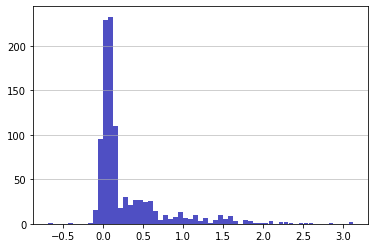

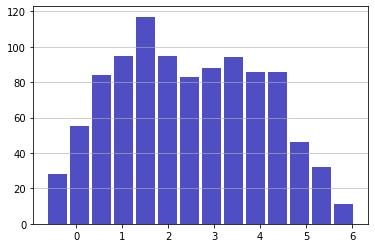

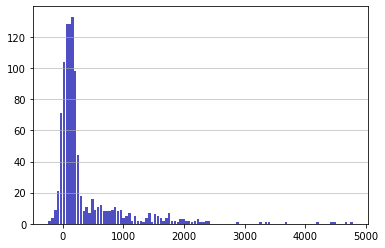

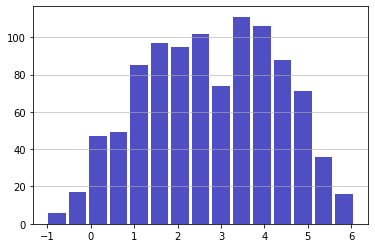

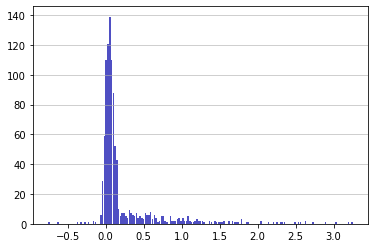

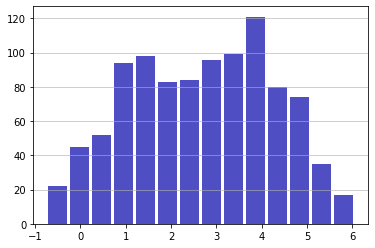

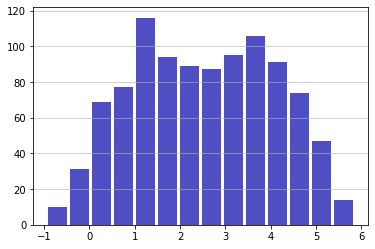

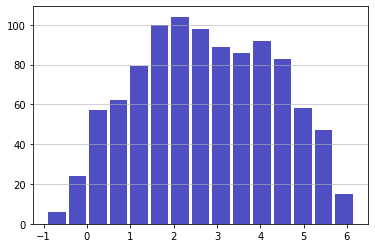

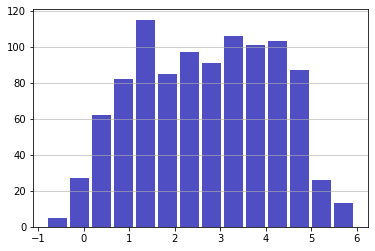

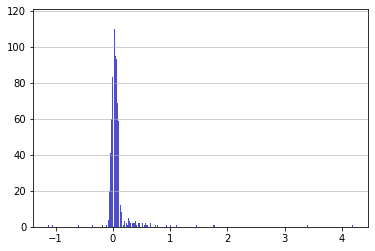

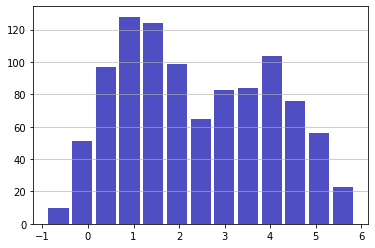

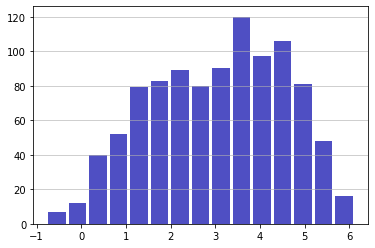

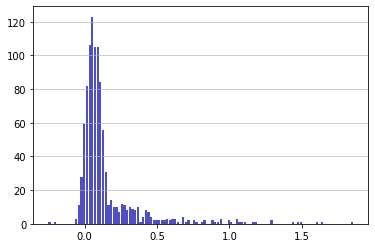

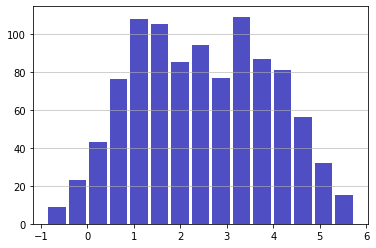

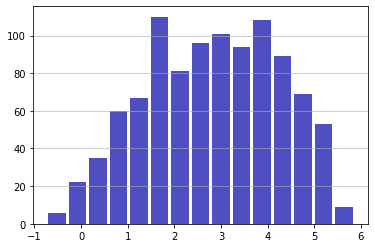

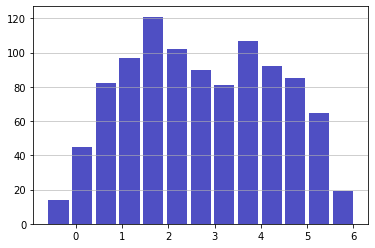

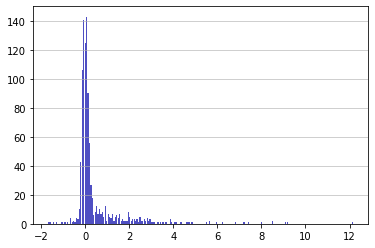

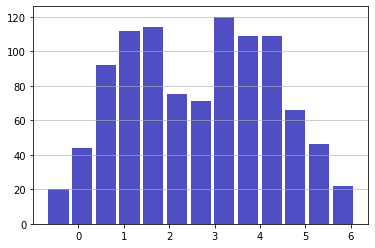

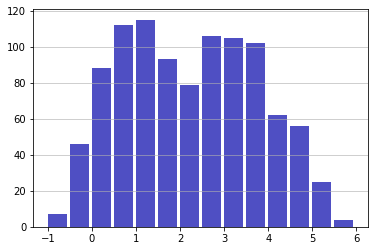

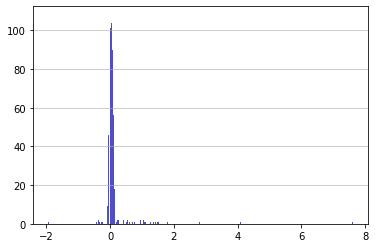

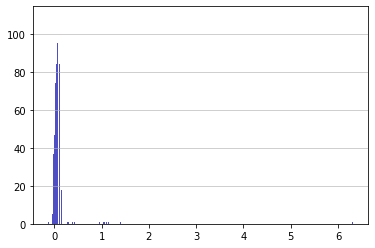

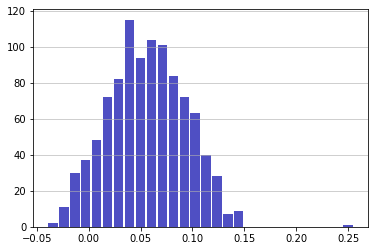

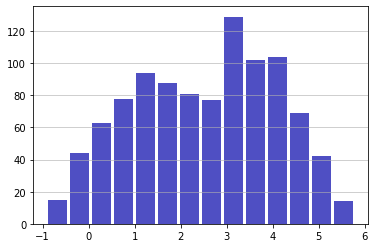

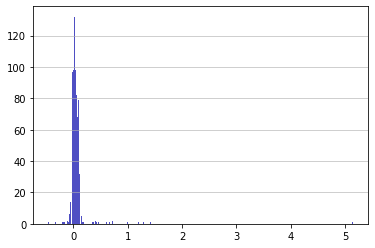

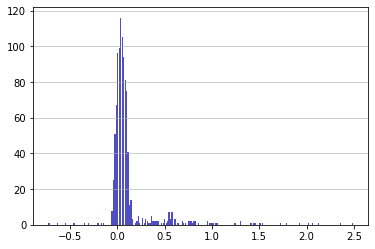

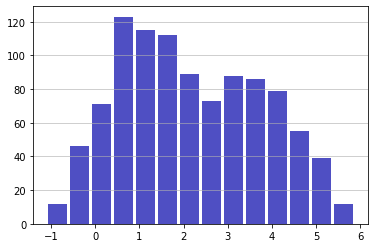

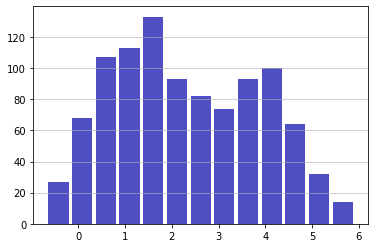

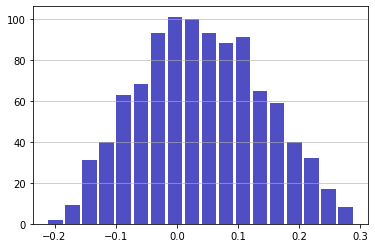

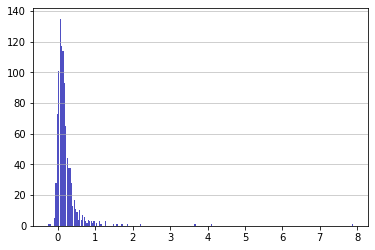

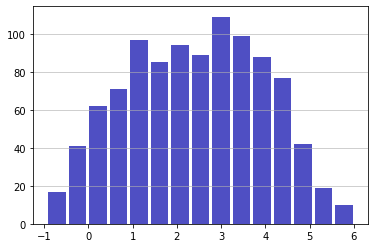

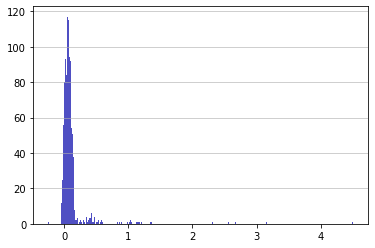

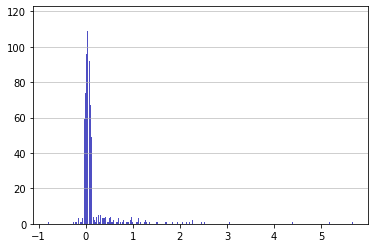

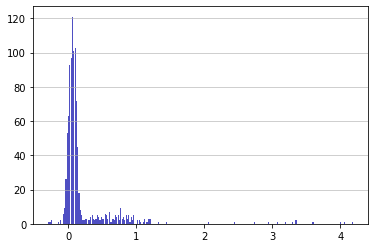

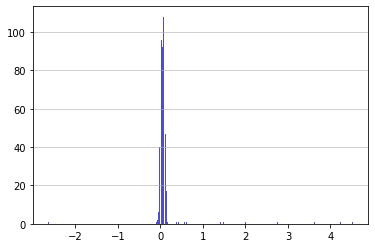

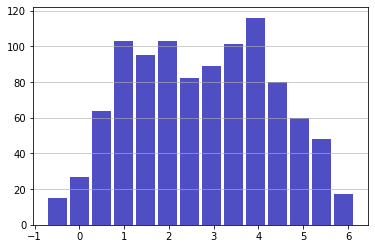

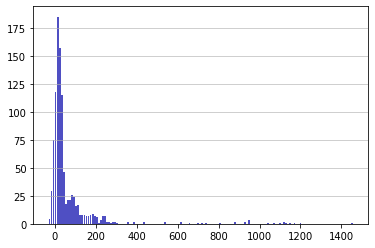

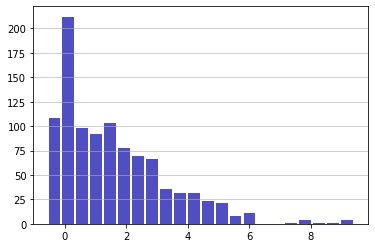

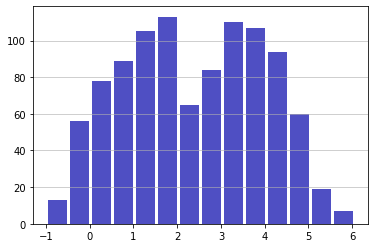

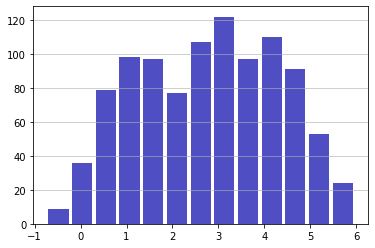

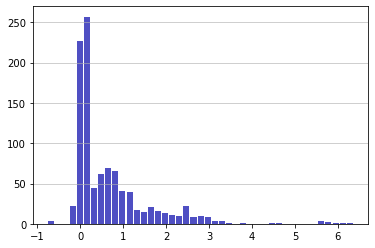

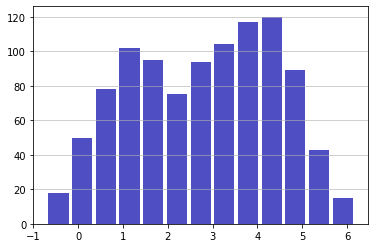

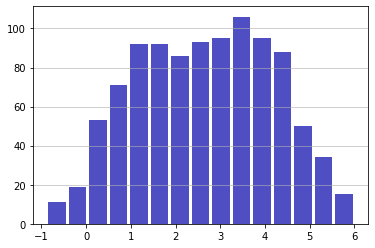

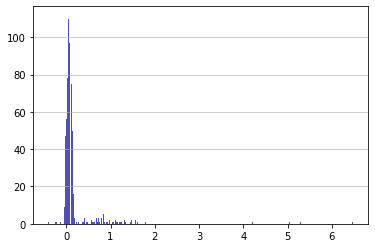

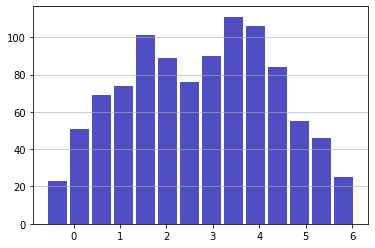

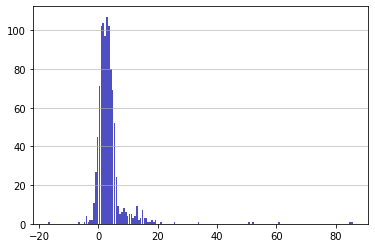

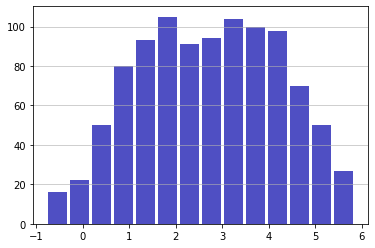

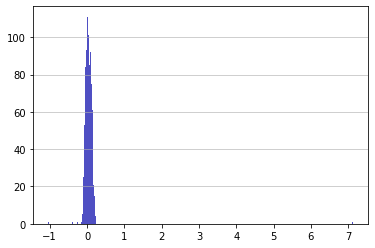

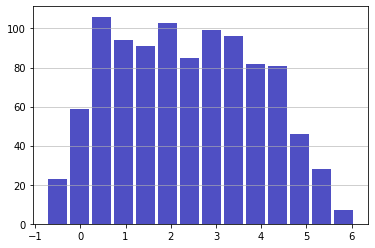

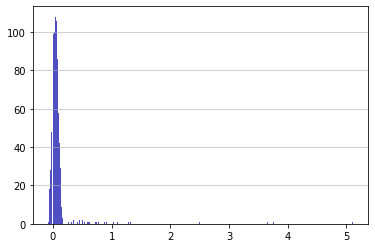

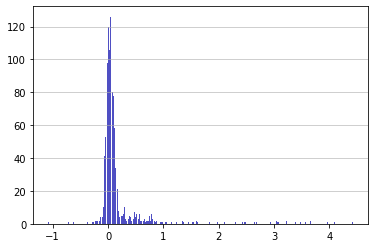

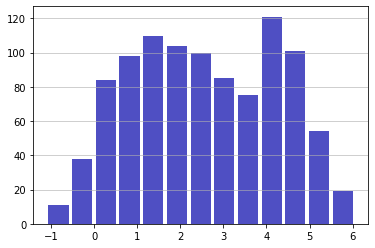

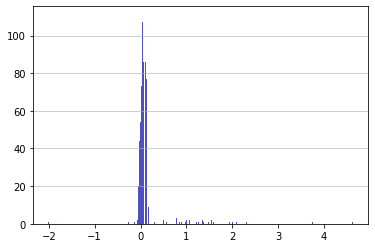

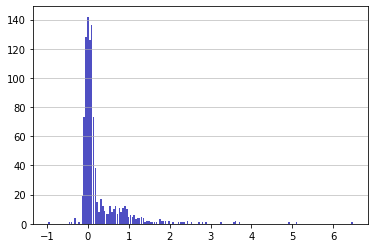

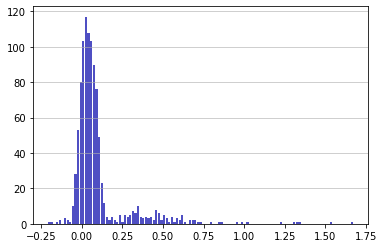

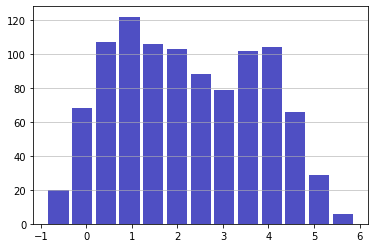

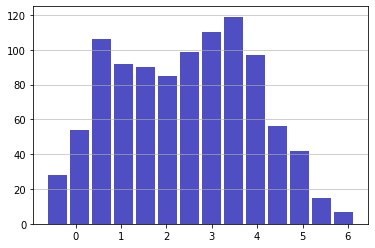

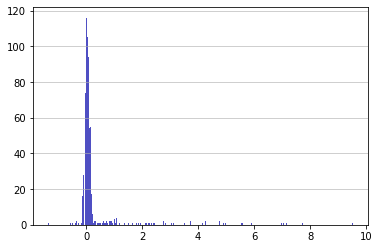

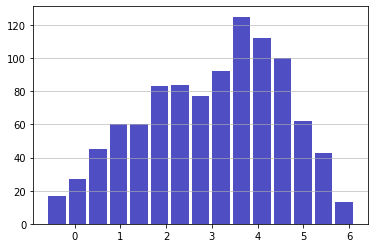

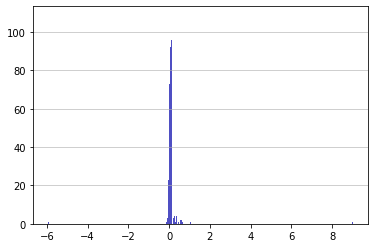

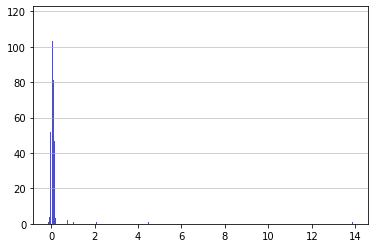

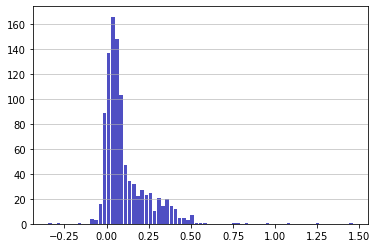

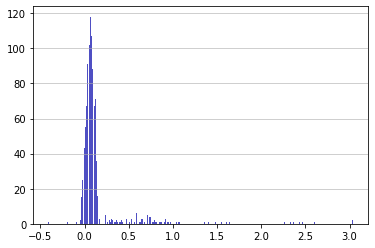

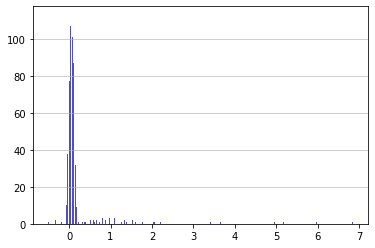

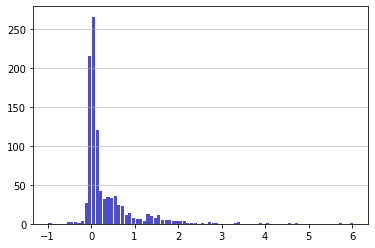

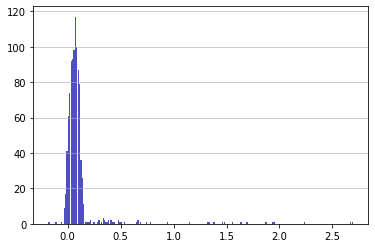

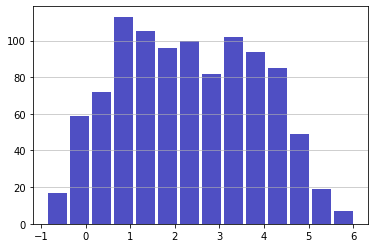

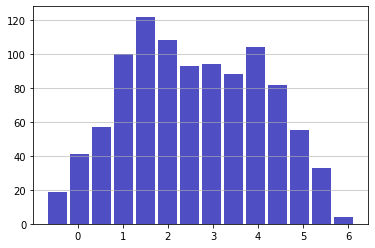

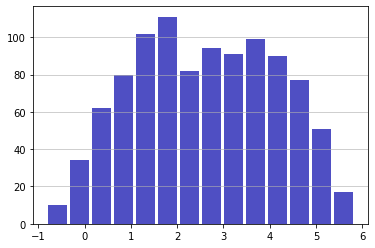

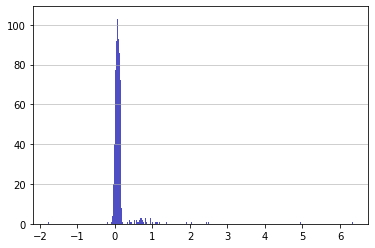

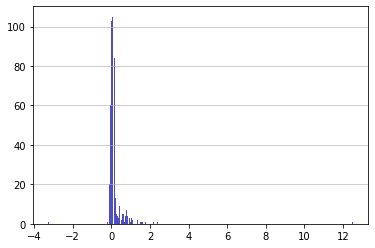

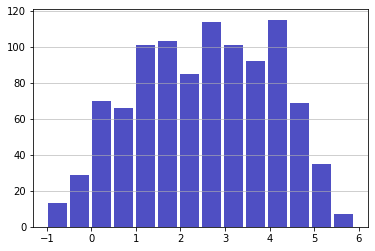

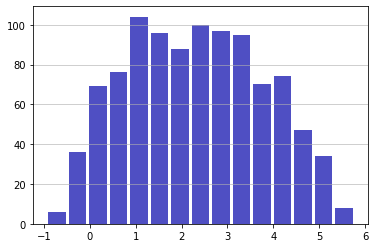

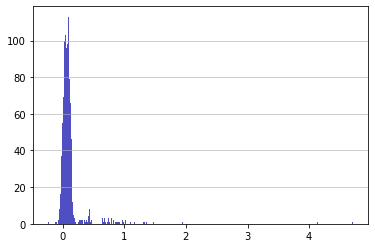

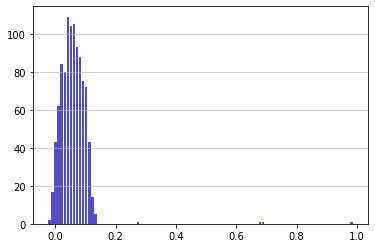

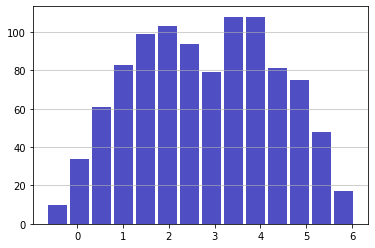

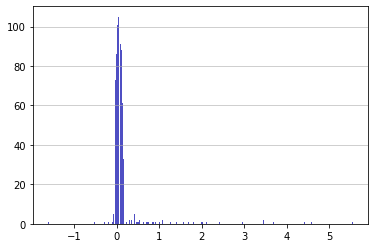

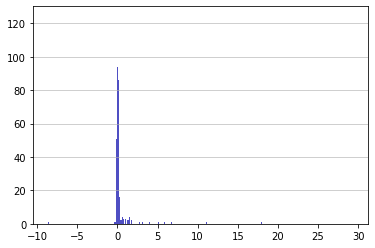

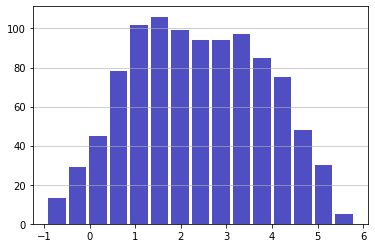

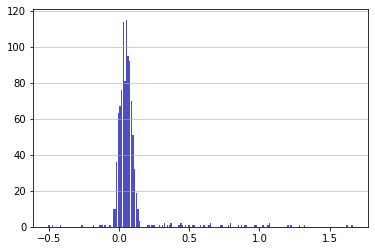

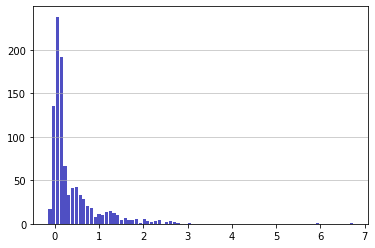

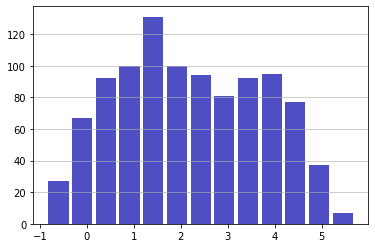

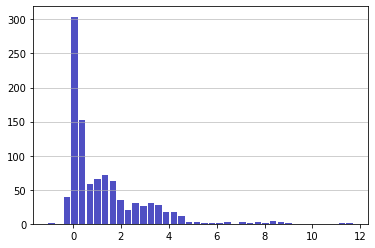

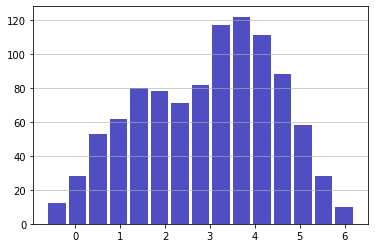

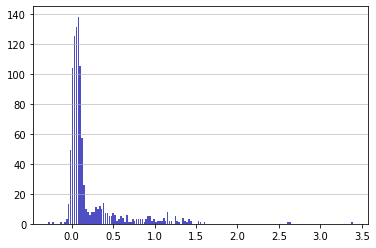

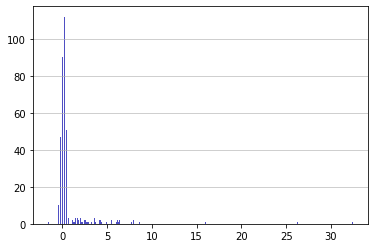

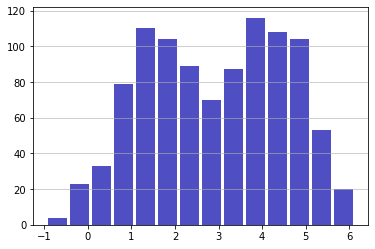

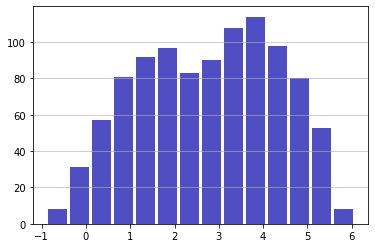

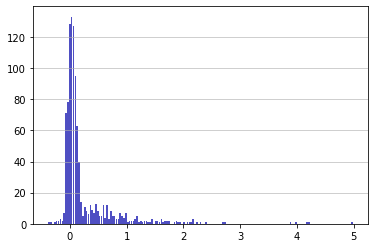

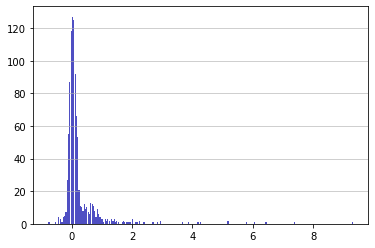

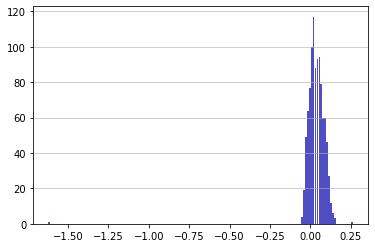

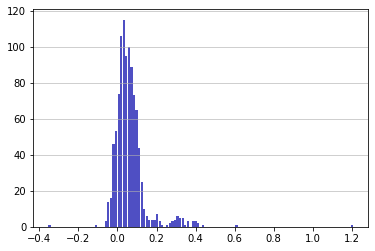

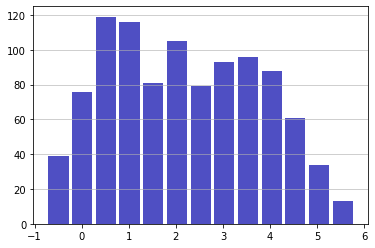

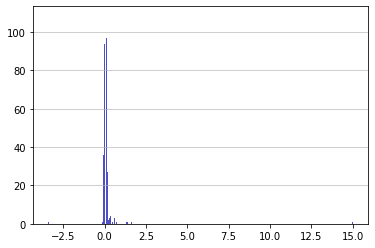

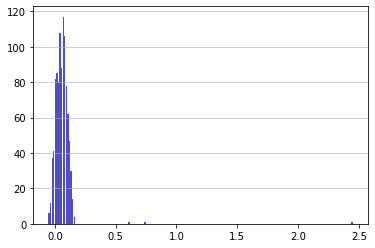

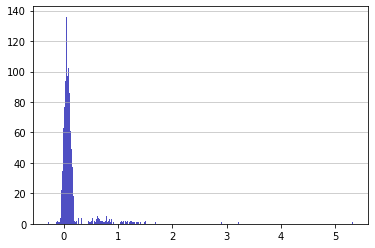

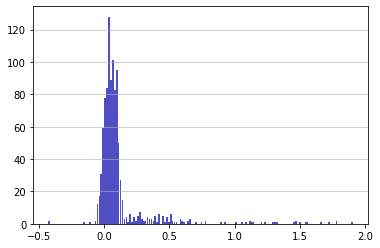

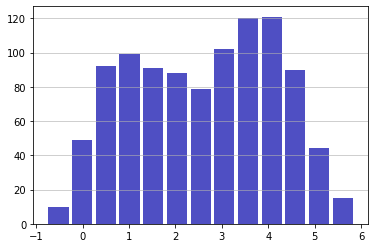

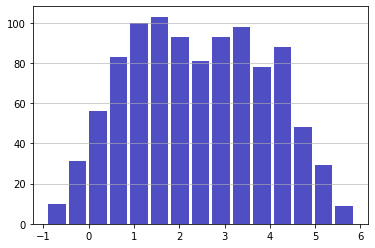

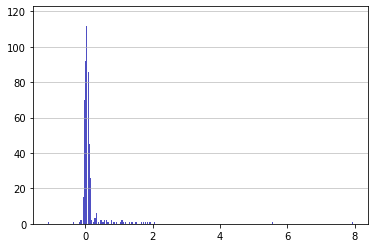

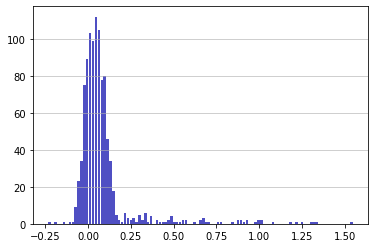

KeyError: "None of [Index(['f100'], dtype='object')] are in the [columns]"

In [40]:
for col in range(test_df.shape[1]-1):
    feat_data = test_df[[f'f{col}']]
    n, bins, patches = plt.hist(x=feat_data, bins='auto', color='#0504aa', 
                            alpha=0.7, rwidth=0.85) 
    plt.grid(axis='y', alpha=0.75)
    plt.show()